#### We are trying to modify the power plants of this grid to obtain this energy mix:
<img src="images/target_em.png" width="30%" height="30%">

In [1]:
import numpy as np
import os
import pandas as pd
import grid2op
from grid2op.Chronics import ChangeNothing
from chronix2grid.kpi.Generator_parameter_checker import EnergyMix_AprioriChecker
import plotly
import plotly.graph_objects as go
from grid2op.PlotGrid import NUKE_COLOR, THERMAL_COLOR, WIND_COLOR, SOLAR_COLOR, HYDRO_COLOR
import json
import copy

# for pandas interactive plots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


/home/donnotben/Documents/chronix2grid_gaetan/venv/lib/python3.8/site-packages/grid2op/Backend/PandaPowerBackend.py:30: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/donnotben/Documents/chronix2grid_gaetan/venv/bin/python -m pip install numba

  warnings.warn("Numba cannot be loaded. You will gain possibly massive speed if installing it by "


#### We load the original prods_charac.csv

In [2]:
env_name = "case118_l2rpn_wcci_benjamin"
path_ref = os.path.join("..", "example", "input", "generation")
path_tmp = os.path.join("..", "example", "custom", "input", "generation")
input_path = os.path.join(path_ref, env_name)
df = pd.read_csv(os.path.join(input_path, "prods_charac.csv"))

avg_pmaxs = df.groupby(["type"])["Pmax"].mean()
types = avg_pmaxs.index.to_numpy()
avg_pmaxs = avg_pmaxs.to_numpy()

In [3]:
df["type"].value_counts()

solar      25
wind       17
nuclear     7
hydro       7
thermal     6
Name: type, dtype: int64

In [4]:
def get_info_by_type(info):
  res = []
  for t in types:
    res.append(df[df["type"] == t].iloc[0][info])
  return np.array(res)

#### We recover some informations about each power plant type

In [5]:
df = pd.read_csv(os.path.join(input_path, "prods_charac.csv"))


n = df.shape[0]
pmaxs = [250.0, 400.0, 74.7, 200.0, 67.2]
max_ramp_up = get_info_by_type("max_ramp_up")
max_ramp_down = get_info_by_type("max_ramp_down")
min_up_time = get_info_by_type("min_up_time")
min_down_time = get_info_by_type("min_down_time")
marginal_cost = get_info_by_type("marginal_cost")
shut_down_cost = get_info_by_type("shut_down_cost")
start_cost = get_info_by_type("start_cost")

In [6]:
df["type"].value_counts()

solar      25
wind       17
nuclear     7
hydro       7
thermal     6
Name: type, dtype: int64

In [7]:
# coppy the prods_charac to the right place
output_path = os.path.join(path_tmp, env_name)
df.to_csv(os.path.join(output_path, "prods_charac.csv"), index=False)

In [8]:
# copy the parameters to the right place
for el in ["params.json", "params_load.json", "params_loss.json", "params_opf.json", "params_res.json"]:
    with open(os.path.join(input_path, el), "r") as f:
        dict_ = json.load(f)
    with open(os.path.join(output_path, el), "w", encoding="utf-8") as f:
        json.dump(fp=f, obj=dict_)

In [9]:
capacity_factor = np.array([30, 95, 15, np.nan, 25])
average_load = 2800
capacity_factor_df = pd.DataFrame(data=capacity_factor, columns=['capacity_factor'], index=types)

grid_path = os.path.join(output_path, "grid.json")
env118_withoutchron = grid2op.make(
    output_path,
    test=True,
    grid_path=grid_path, # assign it the 118 grid
    chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
)

# some data usefull later
is_gen_solar = env118_withoutchron.gen_type == "solar"
is_gen_wind = env118_withoutchron.gen_type == "wind"
gen_solar_name = env118_withoutchron.name_gen[is_gen_solar]
gen_wind_name = env118_withoutchron.name_gen[is_gen_wind]
list_gen_renwable = gen_solar_name.tolist()+gen_wind_name.tolist()

min_gen_possible = np.sum(env118_withoutchron.gen_pmin[env118_withoutchron.gen_redispatchable])
max_gen_possible = np.sum(env118_withoutchron.gen_pmax[env118_withoutchron.gen_redispatchable])
max_gen_up_possible = np.sum(env118_withoutchron.gen_max_ramp_up[env118_withoutchron.gen_redispatchable])
max_gen_down_possible = np.sum(env118_withoutchron.gen_max_ramp_down[env118_withoutchron.gen_redispatchable])
loss_ratio = 0.95  # takes into account some loss (conservative)

plot the grid, to know where are the generators

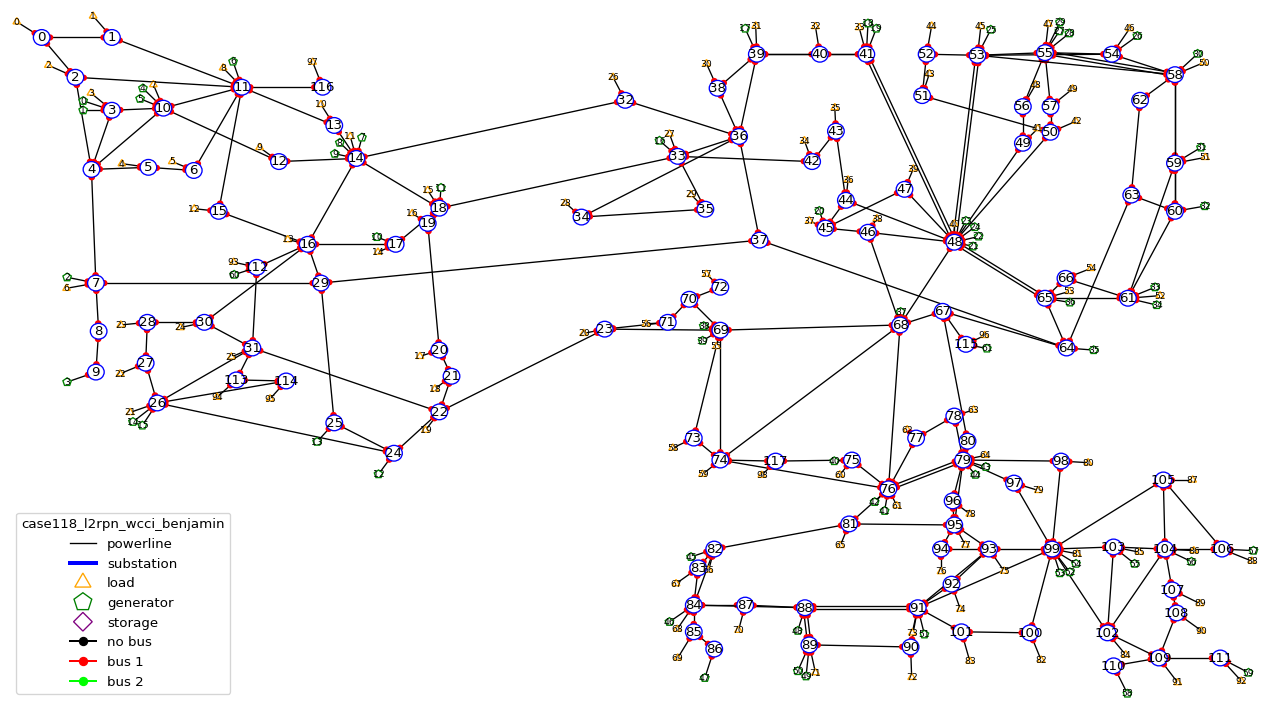

In [10]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env118_withoutchron)
_ = plot_helper.plot_layout()

For information, you can check the "bus" (blue circle) in the "bus" column of the prods_charac.csv

On the graph above, generators are green pentagons.

You can also know if from their name.  For example "gen_68_37" is the generator **37** (gen_68_**37**) connected to substation **68** (gen_**68**_37)

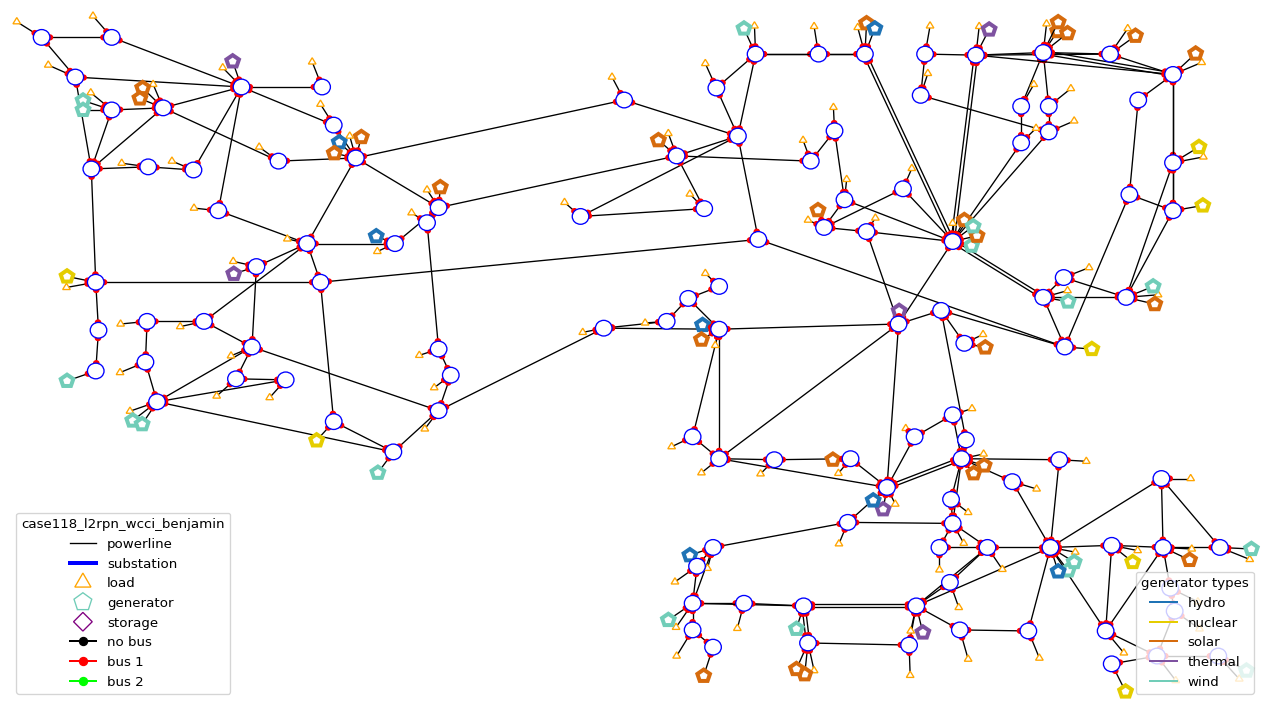

In [11]:
_ = plot_helper.plot_gen_type()

On the figure above you have also the generator types (colored)

#### You can see that the difference between the target energy mix and the apriori energy mix is 45%

# A) We now try to generate the loads / renewable to make sure the generated data are compatible with the grid

In [12]:
calibrate_res = False

In [13]:
### CONSTANT

notebook_folder=%pwd

# define your input folder
INPUT_FOLDER = os.path.join(notebook_folder, '..', 'example', 'custom', 'input')

OUTPUT_FOLDER = os.path.join(notebook_folder, '..', 'example', 'custom', 'output')

# Detailed configuration to be set in <INPUT_FOLDER>/<CASE>/params.json
weeks = 1
n_scenarios = 1
# by_n_weeks = 4  # not used

mode = 'RLTK'
mode = 'RL'


CASE = env_name
# change line 19 of consumptions_utils.py
# day_lag = 6  # this is only TRUE if you simulate 2050 !!!
# if you change the year !!!
li_months = ["2050-01-03", 
             "2050-01-10",
             "2050-01-17",
             "2050-01-24",
             "2050-01-31",
             "2050-02-07",
             "2050-02-14",
             "2050-02-21",
             "2050-02-28",
             "2050-03-07",
             "2050-03-14",
             "2050-03-21",
             "2050-03-28",
             "2050-04-04",
             "2050-04-11",
             "2050-04-18",
             "2050-04-25",
             "2050-05-02", 
             "2050-05-09", 
             "2050-05-16", 
             "2050-05-23", 
             "2050-05-30",
             "2050-06-06",
             "2050-06-13",
             "2050-06-20",
             "2050-06-27",
             "2050-07-04", 
             "2050-07-11", 
             "2050-07-18", 
             "2050-07-25", 
             "2050-08-01", 
             "2050-08-08", 
             "2050-08-15", 
             "2050-08-22", 
             "2050-08-29", 
             "2050-09-05", 
             "2050-09-12", 
             "2050-09-19", 
             "2050-09-26", 
             "2050-10-03", 
             "2050-10-10", 
             "2050-10-17", 
             "2050-10-24", 
             "2050-10-31", 
             "2050-11-07", 
             "2050-11-14", 
             "2050-11-21", 
             "2050-11-28", 
             "2050-12-05",
             "2050-12-12",
             "2050-12-19",
             "2050-12-26",
            ]
np.random.seed(1)
load_seeds = [np.random.randint(0, np.iinfo(np.int32).max) for _ in range(len(li_months))]
renewable_seeds = [np.random.randint(0, np.iinfo(np.int32).max) for _ in range(len(li_months))]

In [14]:
min_ = 0
max_ = 53

In [15]:
%%time
if calibrate_res:
    for i, start_date in enumerate(li_months[min_:max_]):
        cli_chronix2grid = "chronix2grid " \
                            "--mode {} --output-folder {} --input-folder {} --ignore-warnings "\
                            "--weeks {} --case {} --n_scenarios {} --start-date {} "\
                            "--seed-for-loads {}  --seed-for-res {}".format(
                            mode, OUTPUT_FOLDER, INPUT_FOLDER, weeks, CASE, n_scenarios, start_date,
                            load_seeds[i], renewable_seeds[i])
        print(cli_chronix2grid)
        !$cli_chronix2grid
    
# --by-n-weeks {} 
# by_n_weeks

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


#### Load all data

In [16]:
if calibrate_res:
    loads_p = []
    prods_p_renewable = []
    for start_date in li_months[min_:max_]:
        for scen_id in range(n_scenarios):
            path_data_generated = os.path.join(OUTPUT_FOLDER, "generation", CASE, start_date, f"Scenario_{scen_id}")
            loads_p.append(pd.read_csv(os.path.join(path_data_generated, "load_p.csv.bz2"), sep=";"))
            prods_p_renewable.append(pd.read_csv(os.path.join(path_data_generated, "prod_p.csv.bz2"), sep=";"))
    loads_p = pd.concat(loads_p, ignore_index=True)
    prods_p_renewable = pd.concat(prods_p_renewable, ignore_index=True)
    # assert loads_p.shape[0] == len(li_months) * n_scenarios * (weeks * 288 * 7  - 1) 
    # assert prods_p_renewable.shape[0] == len(li_months) * n_scenarios * (weeks * 288 * 7  - 1) 
    total_load = loads_p.sum(axis=1)
    wind_plus_solar = prods_p_renewable[list_gen_renwable].sum(axis=1)
    total_solar = prods_p_renewable[gen_solar_name].sum(axis=1)
    total_wind = prods_p_renewable[gen_wind_name].sum(axis=1)
    residual_load = total_load - wind_plus_solar
    proportion_solar_wind = pd.DataFrame({"total_load": loads_p.sum(axis=1),
                                          "total_solar": prods_p_renewable[gen_solar_name].sum(axis=1),
                                          "total_wind": prods_p_renewable[gen_wind_name].sum(axis=1),
                                         })

#### Some plot to have a look at the generation, might be handy

In [17]:
if calibrate_res:
    prods_p_renewable[gen_wind_name[:3]].iplot()

In [18]:
if calibrate_res:
    prods_p_renewable[gen_solar_name[1]].iplot()

In [19]:
if calibrate_res:
    loads_p.iloc[:,1].iplot()

In [20]:
if calibrate_res:
    fig = go.Figure(data=[go.Scatter(y=total_load, name="total load")])
    fig.add_trace(go.Scatter(y=residual_load, name="residual load"))
    fig.add_trace(go.Scatter(y=wind_plus_solar, name="wind + solar"))
    fig.add_trace(go.Scatter(y=total_solar, name="solar"))
    fig.add_trace(go.Scatter(y=total_wind, name="wind"))
    for el_id, el in enumerate(li_months[min_:max_]):
        fig.add_vline(x=el_id * n_scenarios * (weeks * 288 * 7  - 1),
                      line_dash='dash',
                      line_color="red" if el_id % 4 == 0 else "gray")
    fig.show()

we can compare above with previous validated grid2op environment (uncomment)

In [21]:
import grid2op
if calibrate_res:
    env_name = "l2rpn_neurips_2020_track2_small"
    env_name = "l2rpn_case14_sandbox"
    env_test = grid2op.make(env_name)
    this_env_wind = [i for i in range(env_test.n_gen) if env_test.gen_type[i] == "wind"]

In [22]:
if calibrate_res:
    pd.DataFrame(env_test.chronics_handler.real_data.data.prod_p[:, this_env_wind]).iplot()

In [23]:
if calibrate_res:
    french_ref_data = "ref_french_data"
    all_year_ref = list(range(2012, 2021))
    french_dfs = []
    for year_ in all_year_ref:
        temp_df = pd.read_csv(os.path.join(french_ref_data,
                                           f"eCO2mix_RTE_Annuel-Definitif_{year_}.zip"),
                              sep="\t",
                              encoding="ISO-8859-1",
                              index_col=False)
        french_dfs.append(temp_df)

In [24]:
if calibrate_res:
    fig = go.Figure()
    for i, year_ in enumerate(all_year_ref):
        tmp_ = french_dfs[i]["Eolien"].dropna().values
        tmp_ /= tmp_.max()
        fig.add_trace(go.Scatter(y=tmp_, name=f'{year_}'))
    fig

In [25]:
if calibrate_res:
    fig = go.Figure()
    for i, year_ in enumerate(all_year_ref[-2:]):
        tmp_ = french_dfs[i]["Eolien"].dropna().values
        tmp_ /= tmp_.max()
        fig.add_trace(go.Histogram(x=tmp_, name=f'{year_}'))
    tmp_ = 1.0 * total_wind[::6]  # real data are sampled every 30 mins, I need to do this too here
    tmp_ /= tmp_.max()
    fig.add_trace(go.Histogram(x=tmp_, name="generated (sum)"))
    tmp_ = 1.0 * prods_p_renewable[gen_wind_name[0]].values[::6]  # real data are sampled every 30 mins, I need to do this too here
    tmp_ /= tmp_.max()
    fig.add_trace(go.Histogram(x=tmp_, name="generated (one)"))
    fig

### Expected share of renewables

If everything goes well and there is not much "curtailment"

In [26]:
if calibrate_res:
    labels = ['solar','wind','unknown']
    values = [proportion_solar_wind["total_solar"].sum(),
              proportion_solar_wind["total_wind"].sum(),
              proportion_solar_wind["total_load"].sum() - proportion_solar_wind["total_solar"].sum() - proportion_solar_wind["total_wind"].sum()
             ]

    fig = go.Figure(data=[go.Pie(labels=labels,
                                 values=values,
                                 marker_colors=[SOLAR_COLOR, WIND_COLOR, 'rgba(0,0,0, 0.05)'],
                                 text=[f"{round(el / 12., -3):,.0f} MWh" for el in values])
                         ]
                   )
    fig.update_layout(
        title=f"Repartition of renewable energy sources (upper bound)"
    )
    fig.show()


### Basic infeasibilities

The section bellow check that the market dispatch has a chance to converge. If something is violated here, 
then there is now way the market dispatch can work

In [27]:
if calibrate_res:
    due_pmin = residual_load < min_gen_possible
    due_pmax = residual_load > loss_ratio * max_gen_possible
    delta_gen = residual_load.diff()  # diff(t) = residual_load(t) - residual_load(t-1)
    due_rampmax = delta_gen > max_gen_up_possible
    due_rampmin = delta_gen < -max_gen_up_possible
    due_rampmax[::(7 * 288)] = False  # remove the "interface" at 1 week, 2 weeks etc.
    due_rampmin[::(7 * 288)] = False  # remove the "interface" at 1 weeks, 2 weeks etc.
    print(f"There are (at least) {due_pmin.sum()} infeasibilities due to pmin ({100. * due_pmin.sum() / due_pmin.shape[0]:.0f}%) that will require curtailment")
    print(f"There are (at least) {due_pmax.sum()} infeasibilities due to pmax ({100. * due_pmax.sum() / due_pmax.shape[0]:.0f}%) that will require curtailment")
    print(f"There are (at least) {due_rampmax.sum()} infeasibilities due to ramp up ({100. * due_rampmax.sum() / due_rampmax.shape[0]:.0f}%) that will require curtailment")
    print(f"There are (at least) {due_rampmin.sum()} infeasibilities due to ramp down ({100. * due_rampmin.sum() / due_rampmin.shape[0]:.0f}%) that will require curtailment")
    # assert np.all(~due_pmin) and np.all(~due_pmax) and np.all(~due_rampmax) and np.all(~due_rampmin)

In [28]:
if calibrate_res:
    delta_gen.max()

In [29]:
if calibrate_res:
    max_gen_up_possible

In [30]:
if calibrate_res:
    total_load[-2016:].max()

In [31]:
loss_ratio * max_gen_possible

5367.5

### some basic check to make sure the data are consistent with what we asked

In [32]:
if calibrate_res:
    all_solar_above_pmax = prods_p_renewable[gen_solar_name] > env118_withoutchron.gen_pmax[is_gen_solar]
    all_solar_below_pmin = prods_p_renewable[gen_solar_name] < env118_withoutchron.gen_pmin[is_gen_solar]

    all_wind_above_pmax = prods_p_renewable[gen_wind_name] > env118_withoutchron.gen_pmax[is_gen_wind]
    all_wind_below_pmin = prods_p_renewable[gen_wind_name] < env118_withoutchron.gen_pmin[is_gen_wind]

    assert np.all(all_solar_above_pmax.sum() == 0), f"some solar are above pmax:\n{all_solar_above_pmax.sum()}"
    assert np.all(all_solar_below_pmin.sum() == 0), f"some solar are below pmin:\n{all_solar_below_pmin.sum()}"
    assert np.all(all_wind_above_pmax.sum() == 0), f"some wind are above pmax:\n{all_wind_above_pmax.sum()})"
    assert np.all(all_wind_below_pmin.sum() == 0), f"some wind are below pmin:\n{all_wind_below_pmin.sum()}"

In [33]:
if calibrate_res:
    prods_p_renewable[gen_wind_name].max(axis=0)

In [34]:
if calibrate_res:
    env118_withoutchron.gen_pmax[is_gen_wind]

# B) Now start the redispatching

In [35]:
MODE_DISPATCH2 = "RLT"  # do not put the "D" here !
seed_dispatch = 0

In [49]:
%%time
# --> OPF formulation by => week - Analyzing week # 45
# --> OPF formulation by => week - Analyzing week # 52
for i, start_date in enumerate(li_months[min_:max_]):
    cli_chronix2grid2 = "chronix2grid " \
                         "--mode {} --output-folder {} --input-folder {} --ignore-warnings " \
                         "--weeks {} --case {} --n_scenarios {} --start-date {} " \
                         "--seed-for-loads {}  --seed-for-res {} --seed-for-dispatch {}".format(
                         MODE_DISPATCH2, OUTPUT_FOLDER, INPUT_FOLDER, weeks, CASE, n_scenarios, start_date,
                         load_seeds[i], renewable_seeds[i], seed_dispatch)
    print(cli_chronix2grid2)
    !$cli_chronix2grid2

chronix2grid --mode RLT --output-folder /home/donnotben/Documents/chronix2grid_gaetan/getting_started/experiments/../example/custom/output --input-folder /home/donnotben/Documents/chronix2grid_gaetan/getting_started/experiments/../example/custom/input --ignore-warnings --weeks 1 --case case118_l2rpn_wcci_benjamin --n_scenarios 1 --start-date 2050-01-03 --seed-for-loads 1791095845  --seed-for-res 365262088 --seed-for-dispatch 0
/home/donnotben/Documents/chronix2grid_gaetan/venv/lib/python3.8/site-packages/grid2op/Backend/PandaPowerBackend.py:30: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/donnotben/Documents/chronix2grid_gaetan/venv/bin/python -m pip install numba

  warnings.warn("Numba cannot be loaded. You will gain possibly massive speed if installing it by "
case118_l2rpn_wcci_benjamin
initial_seeds
{'loads': 1791095845, 'renewables': 365262088, 'dispatch': 0}
seeds for scenario: Scenario_0
{'loads': 1791095845, 'renewables'

In [37]:
loads_p2 = []
prods_p_total = []
prods_p_total_gen = []
failed = False
for start_date in li_months[min_:max_]:
    for scen_id in range(n_scenarios):
        path_data_generated = os.path.join(OUTPUT_FOLDER, "generation", CASE, start_date, f"Scenario_{scen_id}")
        if os.path.exists(os.path.join(path_data_generated, "DISPATCH_FAILED")):
            # dispatched has failed for this one
            print(f"Dispatch failed for {start_date} (scenario {scen_id})")
            failed = True
            continue
        loads_p2.append(pd.read_csv(os.path.join(path_data_generated, "load_p.csv.bz2"), sep=";"))
        prods_p_total.append(pd.read_csv(os.path.join(path_data_generated, "prod_p.csv.bz2"), sep=";"))
        prods_p_total_gen.append(pd.read_csv(os.path.join(path_data_generated, "prod_p_renew_orig.csv.bz2"),
                                             sep=";"))
    
loads_p2 = pd.concat(loads_p2, ignore_index=True)
prods_p_total = pd.concat(prods_p_total, ignore_index=True)
prods_p_total_gen = pd.concat(prods_p_total_gen, ignore_index=True)

assert not failed, "some weeks did not converge"
assert loads_p2.shape[0] == len(li_months) * n_scenarios * (weeks * 288 * 7  - 1) 
assert prods_p_total.shape[0] == len(li_months) * n_scenarios * (weeks * 288 * 7  - 1) 
assert prods_p_total_gen.shape[0] == len(li_months) * n_scenarios * (weeks * 288 * 7  - 1) 

assert loads_p2.isna().sum().sum() == 0, "there are nans in the loads"
assert prods_p_total.isna().sum().sum() == 0, f"there are {prods_p_total.isna().sum().sum()} nans in the generators"
assert prods_p_total_gen.isna().sum().sum() == 0, f"there are {prods_p_total_gen.isna().sum().sum()} nans in the generators (max values)"

In [38]:
gen_solar_name2 = env118_withoutchron.name_gen[env118_withoutchron.gen_type == "solar"]
gen_wind_name2 = env118_withoutchron.name_gen[env118_withoutchron.gen_type == "wind"]
gen_hydro_name2 = env118_withoutchron.name_gen[env118_withoutchron.gen_type == "hydro"]
gen_nuclear_name2 = env118_withoutchron.name_gen[env118_withoutchron.gen_type == "nuclear"]
gen_thermal_name2 = env118_withoutchron.name_gen[env118_withoutchron.gen_type == "thermal"]
residual_load = loads_p2.sum(axis=1) - prods_p_total.sum(axis=1)
proportion_solar_wind2 = pd.DataFrame({"total_load": loads_p2.sum(axis=1),
                                      "total_solar": prods_p_total[gen_solar_name2].sum(axis=1),
                                      "total_wind": prods_p_total[gen_wind_name2].sum(axis=1),
                                      "total_hydro": prods_p_total[gen_hydro_name2].sum(axis=1),
                                      "total_nuclear": prods_p_total[gen_nuclear_name2].sum(axis=1),
                                      "total_thermal": prods_p_total[gen_thermal_name2].sum(axis=1),
                                     })

In [39]:
labels2 = ['solar','wind','hydro', "nuclear", "thermal"]
values2 = [proportion_solar_wind2["total_solar"].sum(),
           proportion_solar_wind2["total_wind"].sum(),
           proportion_solar_wind2["total_hydro"].sum(),
           proportion_solar_wind2["total_nuclear"].sum(),
           proportion_solar_wind2["total_thermal"].sum(),
          ]

fig = go.Figure(data=[go.Pie(labels=labels2,
                             values=values2,
                             marker_colors=[SOLAR_COLOR, WIND_COLOR, HYDRO_COLOR, NUKE_COLOR, THERMAL_COLOR],
                            text=[f"{round(el / 12., -3):,.0f} MWh" for el in values2]
                            )]
                             
                )
fig.update_layout(
    title=f"Share of energy produced depending on energy type"
)
fig.show()

### Check the "OPF" did not curtail too much

Be carefull, there are "noise" in the generation now ! This is why the "prod_p_renew_orig" has been loaded and is used here !

In [ ]:
# due to rounding
assert np.all((prods_p_total[gen_wind_name] - prods_p_total_gen[gen_wind_name2]).max() <= 0.100001)

In [ ]:
# max amount "curtailed" by the optimiser, we should get close to 0.
(prods_p_total[gen_wind_name] - prods_p_total_gen[gen_wind_name2]).min()

In [ ]:
# all of that should be really, really close to 0., it's the amount
# of energy "lost" because of constraints on the controlable generators
total_curtailed_generation_pct = 100. * (prods_p_total[gen_wind_name] - prods_p_total_gen[gen_wind_name2]).abs().sum() / prods_p_total_gen[gen_wind_name].sum()
print(total_curtailed_generation_pct)
assert np.all(total_curtailed_generation_pct <= 0.6) # below 0.5% is ok, 0.6-0.7 is a maximum
# TODO check this by month !

In [ ]:
#prods_p_total_gen[gen_wind_name2[0]].iplot()
nm_gen = gen_wind_name[0]
fig = go.Figure(data=[go.Scatter(y=prods_p_total[nm_gen], name="actual generation"),
                      go.Scatter(y=prods_p_total_gen[nm_gen], name="possible generation"),
                     ]
               )
fig.update_layout(
    title=f"Comparison of generation for wind generator {nm_gen}"
)
fig.show()

In [ ]:
# due to rounding
assert np.all((prods_p_total[gen_solar_name] - prods_p_total_gen[gen_solar_name2]).max() <= 0.100001)

In [ ]:
# max amount "curtailed" by the optimiser, we should get close to 0.
(prods_p_total[gen_solar_name] - prods_p_total_gen[gen_solar_name2]).min()

In [ ]:
# all of that should be really, really close to 0., it's the amount
# of energy "lost" because of constraints on the controlable generators
total_curtailed_generation_pct = 100. * (prods_p_total[gen_solar_name] - prods_p_total_gen[gen_solar_name2]).abs().sum() / prods_p_total_gen[gen_solar_name].sum()
print(total_curtailed_generation_pct)
assert np.all(total_curtailed_generation_pct <= 0.1)  # below 0.1% is ok !

In [ ]:
nm_gen = gen_solar_name[0]
fig = go.Figure(data=[go.Scatter(y=prods_p_total[nm_gen], name="actual generation"),
                      go.Scatter(y=prods_p_total_gen[nm_gen], name="possible generation"),
                     ]
               )
fig.update_layout(
    title=f"Comparison of generation for solar generator {nm_gen}"
)
fig.show()

### Check possible bugs

#### check loads meet demands

In [ ]:
ratio_loss = prods_p_total.sum(axis=1) / loads_p.sum(axis=1)
print(ratio_loss.max() - ratio_loss.min())
assert (ratio_loss.max() - ratio_loss.min()) <= 3e-3  # with rounding this can vary a little

#### for renewable generators

In [ ]:
all_solar_above_pmax = prods_p_total[gen_solar_name] > env118_withoutchron.gen_pmax[is_gen_solar]
all_solar_below_pmin = prods_p_total[gen_solar_name] < env118_withoutchron.gen_pmin[is_gen_solar]

all_wind_above_pmax = prods_p_total[gen_wind_name] > env118_withoutchron.gen_pmax[is_gen_wind]
all_wind_below_pmin = prods_p_total[gen_wind_name] < env118_withoutchron.gen_pmin[is_gen_wind]

assert np.all(all_solar_above_pmax.sum() == 0), f"some solar are above pmax:\n{all_solar_above_pmax.sum()}"
assert np.all(all_solar_below_pmin.sum() == 0), f"some solar are below pmin:\n{all_solar_below_pmin.sum()}"
assert np.all(all_wind_above_pmax.sum() == 0), f"some wind are above pmax:\n{all_wind_above_pmax.sum()})"
assert np.all(all_wind_below_pmin.sum() == 0), f"some wind are below pmin:\n{all_wind_below_pmin.sum()}"


#### for the others

In [ ]:
def check_controlable_gens(gen_name, env, prods_p_total):
    pmax_ = np.array([env.gen_pmax[np.where(env.name_gen == nm_)[0]] for nm_ in gen_name])
    pmax_ = pmax_.ravel()
    check_pmax = prods_p_total[gen_name] > pmax_

    pmin_ = np.array([env.gen_pmin[np.where(env.name_gen == nm_)[0]] for nm_ in gen_name])
    pmin_ = pmin_.ravel()
    check_pmin = prods_p_total[gen_name] < pmin_

    max_up_ = np.array([env.gen_max_ramp_up[np.where(env.name_gen == nm_)[0]] for nm_ in gen_name])
    max_up_ = max_up_.ravel()
    max_down_ = np.array([env.gen_max_ramp_down[np.where(env.name_gen == nm_)[0]] for nm_ in gen_name])
    max_down_ = max_down_.ravel()
    delta_gen_ = prods_p_total[gen_name].diff()  # prods_p_total.diff(t) = prods_p_total(t) - prods_p_total(t-1)
    check_max_up = delta_gen_ > max_up_
    check_max_down = delta_gen_ < -max_down_
    # remove the "interface" between the months
    check_max_up[::(weeks * 7 * 288 - 1)] = False
    check_max_down[::(weeks * 7 * 288 - 1)] = False
    check_max_up[::(weeks * 7 * 288 )] = False
    check_max_down[::(weeks * 7 * 288)] = False
    return check_pmax, check_pmin, check_max_up, check_max_down

def check_all_controlable_gens(prods_p_total, gen_hydro_name2, gen_nuclear_name2, gen_thermal_name2, env118_withoutchron):
    check_pmax_hydro, check_pmin_hydro, check_max_up_hydro, check_max_down_hydro = check_controlable_gens(
        gen_hydro_name2, env118_withoutchron, prods_p_total)
    check_pmax_nuclear, check_pmin_nuclear, check_max_up_nuclear, check_max_down_nuclear = check_controlable_gens(
        gen_nuclear_name2, env118_withoutchron, prods_p_total)
    check_pmax_thermal, check_pmin_thermal, check_max_up_thermal, check_max_down_thermal = check_controlable_gens(
        gen_thermal_name2, env118_withoutchron, prods_p_total)

    errors = []
    if not np.all(check_pmax_hydro.sum() == 0):
        errors.append(f"some hydro are above pmax:\n{check_pmax_hydro.sum()}")
    if not np.all(check_pmin_hydro.sum() == 0):
        errors.append(f"some hydro are below pmin:\n{check_pmin_hydro.sum()}")
    if not np.all(check_max_up_hydro.sum() == 0):
        errors.append(f"some hydro are above max_up:\n{check_max_up_hydro.sum()}")
    if not np.all(check_max_down_hydro.sum() == 0):
        errors.append(f"some hydro are below max_down:\n{check_max_down_hydro.sum()}")

    if not np.all(check_pmax_nuclear.sum() == 0):
        errors.append(f"some nuclear are above pmax:\n{check_pmax_nuclear.sum()}")
    if not np.all(check_pmin_nuclear.sum() == 0):
        errors.append(f"some nuclear are below pmin:\n{check_pmin_nuclear.sum()}")
    if not np.all(check_max_up_nuclear.sum() == 0):
        errors.append(f"some nuclear are above max_up:\n{check_max_up_nuclear.sum()}")
    if not np.all(check_max_down_nuclear.sum() == 0):
        errors.append(f"some nuclear are below max_down:\n{check_max_down_nuclear.sum()}")

    if not np.all(check_pmax_thermal.sum() == 0):
        errors.append(f"some thermal are above pmax:\n{check_pmax_thermal.sum()}")
    if not np.all(check_pmin_thermal.sum() == 0):
        errors.append(f"some thermal are below pmin:\n{check_pmin_thermal.sum()}")
    if not np.all(check_max_up_thermal.sum() == 0):
        errors.append(f"some thermal are above max_up:\n{check_max_up_thermal.sum()}")
    if not np.all(check_max_down_thermal.sum() == 0):
        errors.append(f"some thermal are below max_down:\n{check_max_down_thermal.sum()}")

    return errors

errors = check_all_controlable_gens(prods_p_total, gen_hydro_name2, gen_nuclear_name2, gen_thermal_name2, env118_withoutchron)
if len(errors) != 0:
    for el in errors:
        print(el)
print(f"It's now time to look at the 'KPI' and the productions / loads generated at :\n\t{path_data_generated}")

In [ ]:
errors

# C) Fix the loss of the grid

Make sure the data generated can be loaded with grid2op framework

This part might not work on microsoft windows...

In [40]:
from grid2op.Parameters import Parameters
from lightsim2grid import LightSimBackend  # might need "pip install lightsim2grid"
import shutil
from grid2op.Chronics import FromNPY
# TODO TQDM !

path_chronics_outputopf = os.path.join(OUTPUT_FOLDER, "all_scenarios")
shutil.rmtree(path_chronics_outputopf)
if not os.path.exists(path_chronics_outputopf):
    os.mkdir(path_chronics_outputopf)
    
path_chronics_fixed = os.path.join(OUTPUT_FOLDER, "fixed_chronics")

In [41]:
for start_date in li_months:
    for scen_id in range(n_scenarios):
        path_data_generated = os.path.join(OUTPUT_FOLDER, "generation", CASE, start_date, f"Scenario_{scen_id}")
        path_ = os.path.abspath(os.path.join(path_chronics_outputopf, f"{start_date}_{scen_id}"))
        if os.path.exists(os.path.join(path_data_generated, "DISPATCH_FAILED")):
            # dispatched has failed for this one
            continue
        os.symlink(path_data_generated, path_)

In [ ]:
param = env118_withoutchron.parameters
param.NO_OVERFLOW_DISCONNECTION = True
env_for_loss = grid2op.make(
    output_path,
    test=True,
    grid_path=grid_path, # assign it the 118 grid
    chronics_path=path_chronics_outputopf,
    param=param,
    backend=LightSimBackend()
    )

In [ ]:
slack_id = 37
np.where(env_for_loss.backend.init_pp_backend._grid.gen["slack"])[0]

In [ ]:
def fill_real_gen(target, row_id, obs, env, prev=None, slack_id=None, rounding_margin=0.2):
    target[row_id, env.gen_renewable] = obs.gen_p[env.gen_renewable]
    loss = np.sum(obs.gen_p) - np.sum(obs.load_p)  # actual loss of the grid
    # if False:

    # split what the slack absorbed in the controlable generators
    gen_p_setpoint = env.chronics_handler.real_data.data.prod_p[row_id]
    to_split = np.sum(obs.gen_p) - np.sum(gen_p_setpoint)
    total_margin = None
    delta_previous = 0.

    can_adjust = copy.deepcopy(~env.gen_renewable)
    can_adjust[slack_id] = False
    slack_abs = gen_p_setpoint[slack_id]  # obs.gen_p[slack_id]  # gen_p_setpoint[slack_id]
    
    slack_id_controlable = np.where(np.arange(obs.n_gen)[can_adjust] == slack_id)[0]
    
    if to_split > 0.:
        total_margin = np.minimum(obs.gen_max_ramp_up[can_adjust] - delta_previous, 
                                  obs.gen_pmax[can_adjust] - obs.gen_p[can_adjust])
    else:
        total_margin = np.minimum(obs.gen_max_ramp_down[can_adjust] + delta_previous, 
                                  obs.gen_p[can_adjust] - obs.gen_pmin[can_adjust])
            
    if prev is not None:
        delta_previous = gen_p_setpoint[can_adjust] - prev[can_adjust]
        gen_up = delta_previous > 0.
        gen_down = delta_previous < 0.
        
        # there is 4 cases:
        if to_split > 0.:
            # generators up: less margin (because the should "get up more")
            total_margin[gen_up] = np.minimum(obs.gen_pmax[can_adjust][gen_up] - gen_p_setpoint[can_adjust][gen_up],
                                              obs.gen_max_ramp_up[can_adjust][gen_up] + delta_previous[gen_up]
                                              )
            
            # generators down: more margin (because the should get down, but the split is up)
            total_margin[gen_down] = np.minimum(obs.gen_pmax[can_adjust][gen_down] - gen_p_setpoint[can_adjust][gen_down],
                                                obs.gen_max_ramp_up[can_adjust][gen_down] + delta_previous[gen_down]
                                                )
            total_margin[gen_down] = np.minimum(rounding_margin + 0.01, total_margin[gen_down])
        else:
            # generators up: more margin (because the should "get up more")
            total_margin[gen_up] = np.minimum(gen_p_setpoint[can_adjust][gen_up] - obs.gen_pmin[can_adjust][gen_up],
                                              obs.gen_max_ramp_down[can_adjust][gen_up] + delta_previous[gen_up]
                                              )
            
            # generators down: less margin (because the should get down, but the split is up)
            total_margin[gen_down] = np.minimum(gen_p_setpoint[can_adjust][gen_down] - obs.gen_pmin[can_adjust][gen_down],
                                                obs.gen_max_ramp_down[can_adjust][gen_down] + delta_previous[gen_down]
                                                )
            
    total_margin[total_margin < rounding_margin] = 0.
    total_margin[total_margin >= rounding_margin] -= rounding_margin
    
    turned_on = obs.gen_p[can_adjust] > 0.
    if abs(to_split) <= abs(np.sum(total_margin[turned_on])) - rounding_margin:
        # do not turn on turned off generators, because I can
        total_margin[~turned_on] = 0.
    else:
        # print("\t forced to turn on...")
        # total_margin_this = abs(np.sum(total_margin[~turned_off]))
        # needed_margin = abs(to_split) - total_margin_this
        # total_margin[turned_off] /=  total_margin_this
        # total_margin[turned_off] *=  needed_margin
        total_margin[~turned_on] = 0.
        before = 1.0 * to_split
        to_split = np.sign(to_split) * (abs(np.sum(total_margin[turned_on])) - rounding_margin)
    # slack_abs -= to_split
    
    sum_margin = np.sum(total_margin)
    redisp_ = 1.0 * gen_p_setpoint[can_adjust]
    # redisp_ += np.sign(to_split) * total_margin
    if sum_margin == 0.:
        print("no margin for your system !")
    else:
        redisp_ += to_split * total_margin / sum_margin
    target[row_id, can_adjust] = redisp_
    target[row_id, slack_id] = slack_abs
    return loss

In [ ]:
gen_debug_id = 53

final_gen_p = np.full((weeks * 7 * 288 - 1, env_for_loss.n_gen), fill_value=np.NaN, dtype=np.float32)
final_gen_v = np.full((weeks * 7 * 288 - 1, env_for_loss.n_gen), fill_value=np.NaN, dtype=np.float32)
final_load_p = np.full((weeks * 7 * 288 - 1, env_for_loss.n_load), fill_value=np.NaN, dtype=np.float32)
final_load_q = np.full((weeks * 7 * 288 - 1, env_for_loss.n_load), fill_value=np.NaN, dtype=np.float32)
all_loss_orig = np.zeros(weeks * 7 * 288 - 1)

obs = env_for_loss.reset()
i = 0
all_loss_orig[i] = fill_real_gen(final_gen_p, i, obs, env_for_loss, slack_id=slack_id)
final_gen_v[i] = obs.gen_v
final_load_p[i] = obs.load_p
final_load_q[i] = obs.load_q
chron_name = env_for_loss.chronics_handler.get_id()
done = False
prev_ = obs.gen_p
while not done:
    obs, reward, done, info = env_for_loss.step(env_for_loss.action_space())
    i += 1
    all_loss_orig[i] = fill_real_gen(final_gen_p, i, obs, env_for_loss, prev=final_gen_p[i-1], slack_id=slack_id)
    final_gen_v[i] = obs.gen_v
    final_load_p[i] = obs.load_p
    final_load_q[i] = obs.load_q
    # if (final_gen_p[i][gen_debug_id] - final_gen_p[i-1][gen_debug_id]) < -obs.gen_max_ramp_down[gen_debug_id]:
    #     import pdb
    #     pdb.set_trace()
    prev_ = 1.0 * obs.gen_p

In [ ]:
final_gen_df = pd.DataFrame(final_gen_p, columns=env_for_loss.name_gen)
errors = check_all_controlable_gens(final_gen_df, gen_hydro_name2, gen_nuclear_name2, gen_thermal_name2, env118_withoutchron)
if errors:
    for el in errors:
        print(el)
        print()
    raise RuntimeError("some constraints are not met")
print("No errors !")

In [ ]:
# these numbers should be between 1-2-3% (more than 5 indicates an issue !)
losses_pct_orig = 100. * all_loss_orig / np.sum(final_gen_p, axis=1)
print(f"max loss (origin grid): {losses_pct_orig.max():.2f} %")
print(f"min loss (origin grid): {losses_pct_orig.min():.2f} %")
print(f"avg loss (origin grid): {losses_pct_orig.mean():.2f} %")

In [ ]:
# now adjust the generators schedule so that they do not move
cond_ = True
all_loss = 1.0 * all_loss_orig
prev_max_diff = 100000.
while cond_:
    env_fixed = grid2op.make(
        output_path,
        test=True,
        grid_path=grid_path, # assign it the 118 grid
        param=param,
        backend=LightSimBackend(),
        chronics_class=FromNPY,
        chronics_path=path_chronics_outputopf,
        data_feeding_kwargs={"load_p": final_load_p,
                             "load_q": final_load_q,
                             "prod_p": final_gen_p,
                             "prod_v": final_gen_v}
        )
    # this should be as close to 0. as possible...
    # we might do a second "repartition loop" to make sure it's ok :-)
    i = 0
    final_gen_p_tmp = final_gen_p * np.NaN
    diff_ = np.full((weeks * 7 * 288 - 1, env_fixed.n_gen), fill_value=np.NaN)
    all_loss = np.zeros(weeks * 7 * 288 - 1)
    obs = env_fixed.reset()
    diff_[i] = obs.gen_p - final_gen_p[i]
    all_loss[i] = fill_real_gen(final_gen_p_tmp, i, obs, env_for_loss, slack_id=slack_id)
    prev_ = obs.gen_p
    while True:
        obs, reward, done, info = env_fixed.step(env_for_loss.action_space())
        if done:
            break
        i += 1
        all_loss[i] = fill_real_gen(final_gen_p_tmp, i, obs, env_for_loss, prev=final_gen_p_tmp[i-1], slack_id=slack_id)
        diff_[i] = obs.gen_p - final_gen_p_tmp[i]
        prev_ = 1.0 * obs.gen_p
    max_diff = np.abs(diff_).max()
    final_gen_p = 1.0 * final_gen_p_tmp
    print(f"max diff is {max_diff:.2f}")
    if max_diff >= prev_max_diff:
        print("seems to mess something up... stopping here...")
        cond_ = False
        break
    print(prev_max_diff, max_diff)
    prev_max_diff = copy.deepcopy(max_diff)
    cond_ = max_diff > 1

In [ ]:
# these numbers should be between 1-2-3% (more than 5 indicates an issue !)
losses_pct = 100. * all_loss / np.sum(final_gen_p, axis=1)
print(f"max loss: {losses_pct.max():.2f} %")
print(f"min loss: {losses_pct.min():.2f} %")
print(f"avg loss: {losses_pct.mean():.2f} %")
assert losses_pct.max() <= 5

In [ ]:
avg_ = np.mean(losses_pct)
fig = go.Figure(data=[go.Histogram(x=losses_pct)])
# fig.add_trace(go.Scatter(x=[avg_, avg_], y =[0, 100], mode="lines", name="average"))
fig.add_vline(x = avg_, line_dash='dash', line_color="red")
fig.update_layout(title="Loss on the grid (%) [should be around 2-3% on average]")

now that the generation "does not move", we check that it meets the physical constraints

In [ ]:
final_gen_df = pd.DataFrame(final_gen_p, columns=env_for_loss.name_gen)
errors = check_all_controlable_gens(final_gen_df, gen_hydro_name2, gen_nuclear_name2, gen_thermal_name2, env118_withoutchron)
if errors:
    for el in errors:
        print(el)
        print()
    raise RuntimeError("some constraints are not met")

In [ ]:
np.abs(final_gen_df["gen_41_19"].diff()).max()

now we save the data in the right format

In [ ]:
# pd.DataFrame(final_load_p, columns=env_for_loss.name_load).to_csv(...)